### Red Eye Removal

In [1]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import requests
import io

In [2]:
image = plt.imread("red1.jpg")

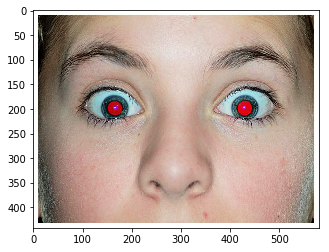

In [3]:
plt.imshow(image)

In [4]:
detector = cv.CascadeClassifier("haarcascade_eye.xml")

In [5]:
eyes = detector.detectMultiScale(image,scaleFactor=1.3,minNeighbors=10,minSize=(50,50)) 

In [6]:
eyes.shape


(2, 4)

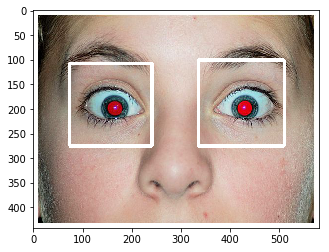

In [7]:
copied=image.copy()
for i in range(0,2):
    x,y,w,h = eyes[i]
    cv.rectangle(copied,(x,y),(x+w,y+h),(255,255,255),5)
plt.imshow(copied)

### EYE CROP

In [8]:
eyes_a = []
for eye in eyes:
    x,y,w,h,= eye
    ey=image[y:y+h,x:x+w]
    eyes_a.append(ey)

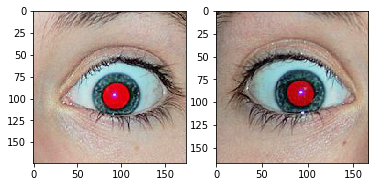

In [9]:
f,a=plt.subplots(1,2)
a[0].imshow(eyes_a[0])
a[1].imshow(eyes_a[1])

## Spliting in the RBG Format

In [10]:
eye1 = eyes_a[0]

In [11]:
r = eye1[:,:,0]
g = eye1[:,:,1]
b = eye1[:,:,2]

Text(0.5, 1.0, 'Blue')

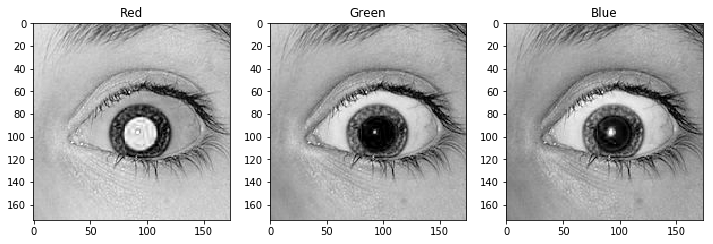

In [12]:
f,a = plt.subplots(1,3,figsize=(12,5))
a[0].imshow(r,cmap='gray')
a[0].set_title("Red")
a[1].imshow(g,cmap='gray')
a[1].set_title("Green")
a[2].imshow(b,cmap="gray")
a[2].set_title("Blue")

### THRESHOLDING

Text(0.5, 1.0, 'Combined Thresholding')

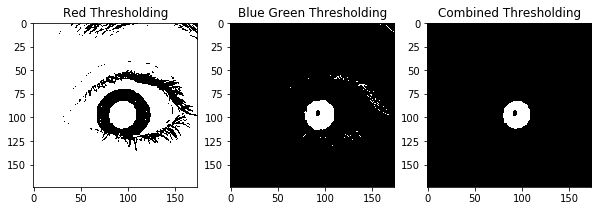

In [13]:
#thresholding to detect the red area
red_thres =(r>130)
blue_green_thres = (r>cv.add(b,g))
combined_thres = red_thres & blue_green_thres 

f,a = plt.subplots(1,3,figsize=(10,5))
a[0].imshow(red_thres,cmap='gray')
a[0].set_title("Red Thresholding")

a[1].imshow(blue_green_thres,cmap='gray')
a[1].set_title("Blue Green Thresholding")

a[2].imshow(combined_thres,cmap='gray')
a[2].set_title("Combined Thresholding")


# Checking for differnt param
# a[0].imshow(red_thres)
# a[1].imshow(blue_green_thres)
# a[2].imshow(combined_thres)

### Filling Center Dor

In [14]:
def fill_center_dot(mask):
    #making Copy of mask in we are going to fill
    flood = mask.copy()
    h,w = flood.shape[:2]
    #cretinf temp mask for the flood fill function
    maskTemp = np.zeros((h+2,w+2),np.uint8)
    
    #floodfills algo
    cv.floodFill(flood,maskTemp,(0,0),255)
    inverse_flood = cv.bitwise_not(flood)
    #bitwise orign
    
    return inverse_flood | mask

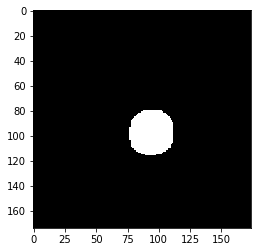

In [15]:
mask = fill_center_dot(combined_thres.astype('uint8'))
mask = cv.dilate(mask,None,iterations=3)
plt.imshow(mask,cmap="gray")

## Final Output


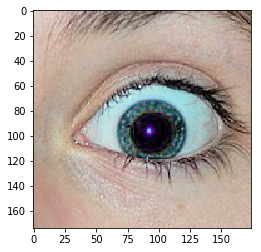

In [16]:
mean_bg = cv.add(b,g)/2
mask=mask.astype('bool')
co = r.copy()
np.copyto(co,mean_bg.astype('uint8'),where=mask)

#combined all three layers
final = np.dstack((co,g,b))

plt.imshow(final,cmap='gray')

In [17]:
def image_process(eye):
    """
    Image should be in Rgb format
    
    """
    r = eye[:, :, 0]
    g = eye[:, :, 1]
    b = eye[:, :, 2]
    
    red_thres=(r>130)
    blue_green_thres=(r>cv.add(b,g))
    combined_thres=red_thres & blue_green_thres
    
    
    mask=fill_center_dot(combined_thres.astype('uint8'))
    mask=cv.dilate(mask,None, iterations=3)
    
    mean_bg=cv.add(b,g)/2
    mask=mask.astype('bool')
    
    red_layer=r.copy()
    np.copyto(red_layer,mean_bg.astype('uint8'),where=mask)
    
    final=np.dstack((red_layer,g,b)).astype("uint8")
    
    return final
    

In [18]:
def pipeline(image):
    image_c=image.copy()
    #detect eyes in it
    eye_detector=cv.CascadeClassifier("haarcascade_eye.xml")
    eyes=eye_detector.detectMultiScale(image_c,scaleFactor=1.3, minNeighbors=10, minSize=(50, 50)) 
    print(len(eyes))
    for eye in eyes:
        x,y,w,h=eye
        
        ey=image_c[y:y+h,x:x+w]
        ey_out=image_process(ey)
        
        #recover image paste on the original image
        
        image_c[y:y+h, x:x+w]=ey_out
        
        
    return image_c
    


2


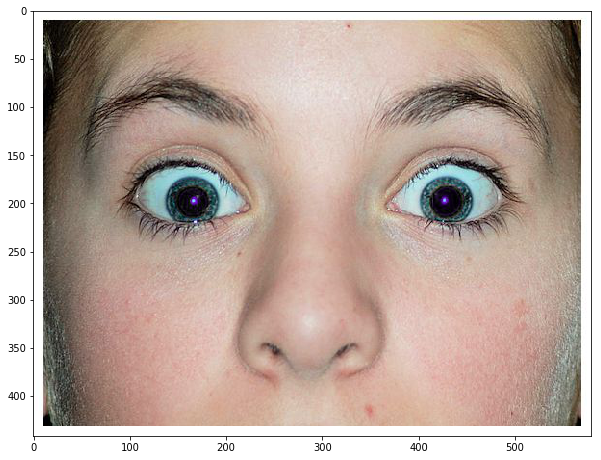

In [19]:
plt.figure(figsize=(10,20))
plt.imshow(pipeline(image))